Before looking at the analysis, I first wanted to explain some of the theory and drawbacks of this method. This method essentially takes in 2 time series objects, and applies something called a two dimensional process to analyze various input for potential "lags" in the data. It is a type of statistical analysis that leverages the properties of Martingales and Continuous time series data. One potential drawback I faced here was the actual data I was able to feed into the model. Since the dataset was extremely large, I performed systematic sampling to take data points from intervals throughout the entire time series, which leads to a loss of precision, but will maintain general trends in the data. This is why only significant results from the below data should be considered, and to come up with more conclusive results, more computational power is required. Full credit for the python library that enabled this goes to Phillipe Remy. The repository can be found here: https://github.com/philipperemy/lead-lag

In [1]:
from lead_lag import LeadLag
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dask.dataframe as dd
from dask.delayed import delayed

In [48]:
def read_parquet(file_path):
    return dd.read_parquet(file_path, columns=['exchange_ts', 'px', 'capture_ts_ns'])

def sort_and_deduplicate(df):
    df = df.sort_values(by=['exchange_ts', 'capture_ts_ns'], ascending=[True, False])
    return df.drop_duplicates(subset='exchange_ts', keep='first')

def process_asset_files(month_path, asset, exchange):
    data_frames = []
    for day in os.listdir(month_path):
        day_path = os.path.join(month_path, day)
        if not os.path.isdir(day_path):
            continue
        
        asset_files = [os.path.join(day_path, f) for f in os.listdir(day_path) if f.endswith('.gzip') and asset in f and exchange in f]
        for file in asset_files:
            data_frames.append(read_parquet(file))
    
    df = dd.concat(data_frames)
    df = df.map_partitions(sort_and_deduplicate)
    df = df.repartition(npartitions=1)
    df = df.map_partitions(sort_and_deduplicate)
    return df.compute().reset_index(drop=True)

def explore_lead_lag(asset, month, exchange1, exchange2):
    month_path = f'../data/{month}'

    # Process files for both exchanges
    df1 = process_asset_files(month_path, asset, exchange1)
    df2 = process_asset_files(month_path, asset, exchange2)
    df1['exchange_ts'] = pd.to_datetime(df1['exchange_ts'], unit='ms')
    df2['exchange_ts'] = pd.to_datetime(df2['exchange_ts'], unit='ms')
    print("Data is processed")
    start_time = max(df1['exchange_ts'].min(), df2['exchange_ts'].min())
    end_time = min(df1['exchange_ts'].max(), df2['exchange_ts'].max())
    buffer_ms = 500
    start_time -= pd.Timedelta(milliseconds=buffer_ms)
    end_time += pd.Timedelta(milliseconds=buffer_ms)
    print(f"From {start_time} til {end_time}")
    df1 = df1[(df1['exchange_ts'] >= start_time) & (df1['exchange_ts'] <= end_time)]
    df2 = df2[(df2['exchange_ts'] >= start_time) & (df2['exchange_ts'] <= end_time)]
    df1.set_index('exchange_ts', inplace=True)
    df2.set_index('exchange_ts', inplace=True)

    # Perform systematic sampling
    sample_size1 = int(len(df1) * 0.02)
    sample_size2 = int(len(df2) * 0.02)
    interval1 = len(df1) // sample_size1
    interval2 = len(df2) // sample_size2
    sample1 = df1.iloc[::interval1]
    sample2 = df2.iloc[::interval2]

    print("Data is filtered")
    print(f"New lengths: {len(sample1), len(sample2)}")

    # Lead-Lag analysis
    ll = LeadLag(
        ts1=sample1['px'].copy(),
        ts2=sample2['px'].copy(),
        max_lag=2,  # in seconds
        verbose=False,
        min_precision=0.01  # in seconds
    )

    print('Running lead-lag inference: ')
    ll.run_inference(num_threads=4)  # faster processing
    print(f'Estimated lag: {ll.lead_lag} seconds. Positive lag means {exchange1} is leading.')
    print(f'LLR: {ll.llr:.2f} (cf. paper for the definition of LLR).')
    ll.plot_results()


Data is processed
From 2024-01-03 02:40:59.405000 til 2024-01-31 23:30:06.121000
Data is filtered
New lengths: (40396, 132528)
Running lead-lag inference: 
Estimated lag: -0.03 seconds. Positive lag means GateIO is leading.
LLR: 0.96 (cf. paper for the definition of LLR).


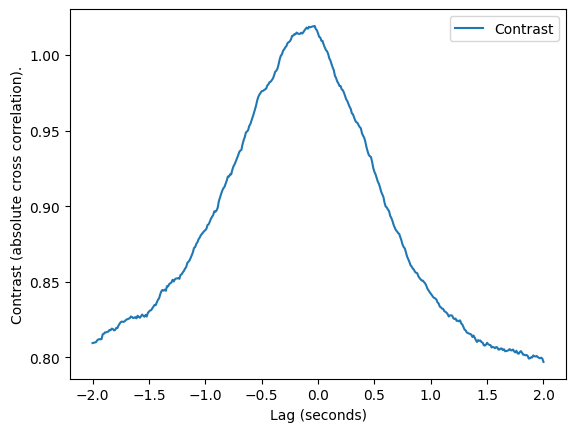

In [49]:
explore_lead_lag('BTC', '01', 'GateIO', 'OKX')

Data is processed
From 2024-01-02 04:23:47.970000 til 2024-01-31 23:30:15.788000
Data is filtered
New lengths: (42140, 199195)
Running lead-lag inference: 
Estimated lag: -0.1 seconds. Positive lag means GateIO is leading.
LLR: 1.02 (cf. paper for the definition of LLR).


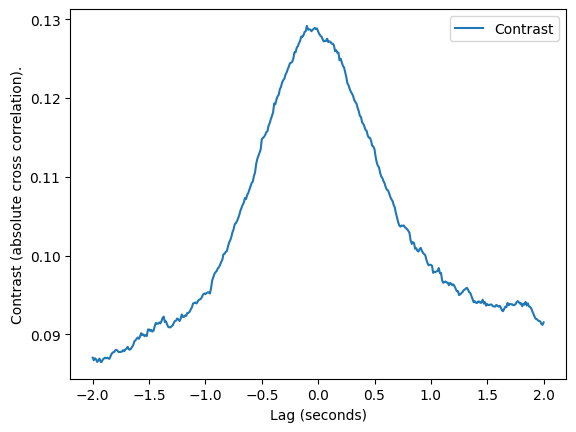

In [50]:
explore_lead_lag('BTC', '01', 'GateIO', 'Binance')

Data is processed
From 2024-01-03 02:40:59.405000 til 2024-01-31 23:30:06.121000
Data is filtered
New lengths: (132528, 185816)
Running lead-lag inference: 
Estimated lag: 0.03 seconds. Positive lag means OKX is leading.
LLR: 1.06 (cf. paper for the definition of LLR).


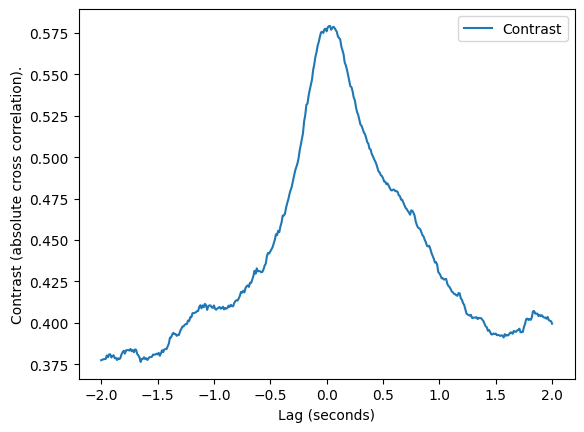

In [52]:
explore_lead_lag('BTC', '01', 'OKX', 'Binance')

In January, there is not much data availible for GateIO, but there is plenty of data availible for OKX and Binance and there is a strong indication that OKX is leading by about 0.03 seconds.

Data is processed
From 2024-01-02 04:24:02.096000 til 2024-01-31 23:30:47.947000
Data is filtered
New lengths: (34656, 94995)
Running lead-lag inference: 
Estimated lag: -0.08 seconds. Positive lag means GateIO is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


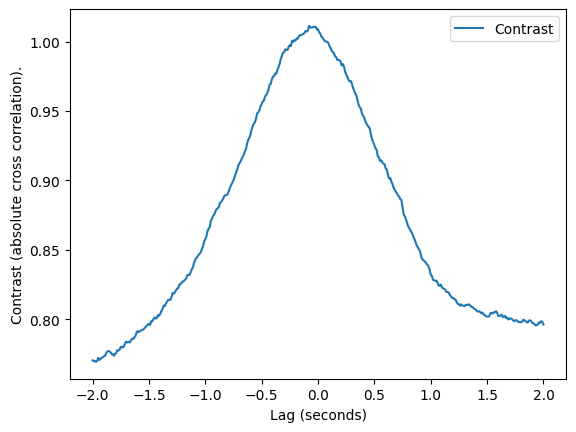

In [53]:
explore_lead_lag('ETH', '01', 'GateIO', 'BybitLinear')

Data is processed
From 2024-01-03 02:40:59.513000 til 2024-01-31 23:30:30.719000
Data is filtered
New lengths: (34373, 127668)
Running lead-lag inference: 
Estimated lag: -0.14 seconds. Positive lag means GateIO is leading.
LLR: 0.97 (cf. paper for the definition of LLR).


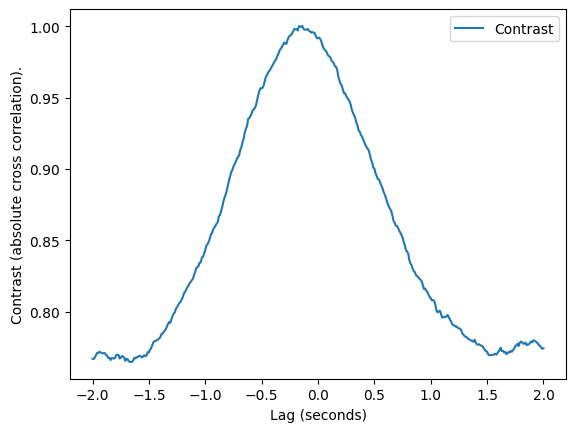

In [54]:
explore_lead_lag('ETH', '01', 'GateIO', 'OKX')

Data is processed
From 2024-01-02 04:24:02.096000 til 2024-01-31 23:30:48.145000
Data is filtered
New lengths: (34656, 151914)
Running lead-lag inference: 
Estimated lag: 0.01 seconds. Positive lag means GateIO is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


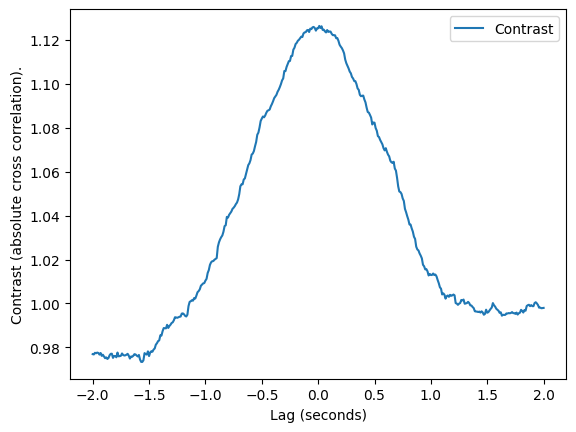

In [55]:
explore_lead_lag('ETH', '01', 'GateIO', 'Binance')

Data is processed
From 2024-01-03 02:40:59.513000 til 2024-01-31 23:30:30.719000
Data is filtered
New lengths: (127668, 142219)
Running lead-lag inference: 
Estimated lag: 0.07 seconds. Positive lag means OKX is leading.
LLR: 1.02 (cf. paper for the definition of LLR).


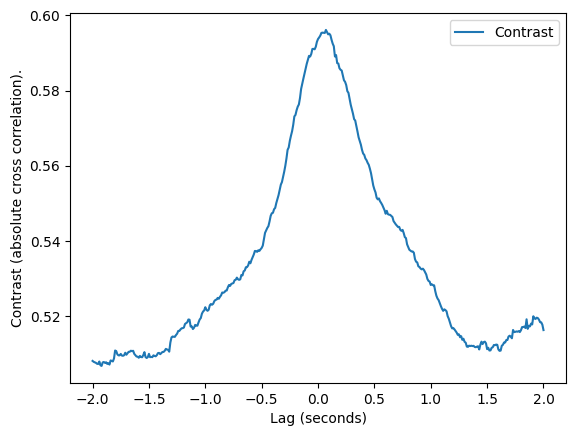

In [56]:
explore_lead_lag('ETH', '01', 'OKX', 'Binance')

Data is processed
From 2024-01-03 02:40:59.513000 til 2024-01-31 23:30:30.719000
Data is filtered
New lengths: (127668, 94263)
Running lead-lag inference: 
Estimated lag: 0.03 seconds. Positive lag means OKX is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


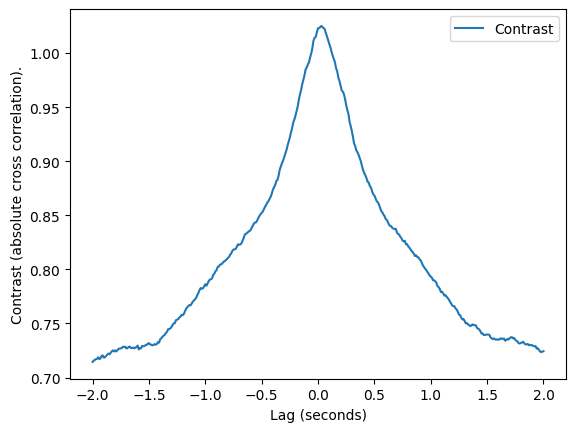

In [57]:
explore_lead_lag('ETH', '01', 'OKX', 'BybitLinear')

Data is processed
From 2024-01-02 04:23:42.619000 til 2024-01-31 23:30:47.947000
Data is filtered
New lengths: (94996, 151915)
Running lead-lag inference: 
Estimated lag: -0.04 seconds. Positive lag means BybitLinear is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


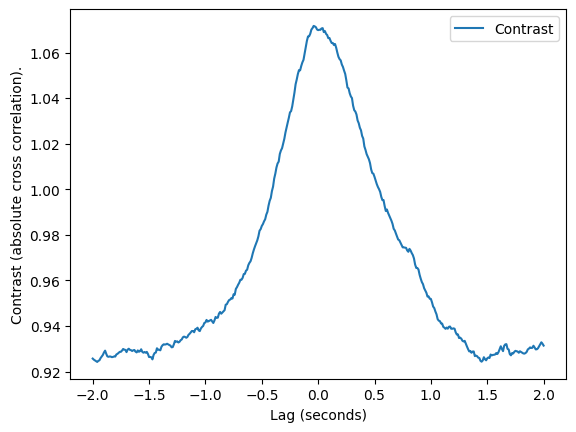

In [58]:
explore_lead_lag('ETH', '01', 'BybitLinear', 'Binance')

In January for ETH, similarly, there is not much availible data for GateIO but there is plenty data points to go off of for OKX, Binance, and BybitLinear. The relationship between Binance and ByBitLinear doesn't seem to very discernible but OKX seems to clearly be slighly ahead of both exchanges.

Data is processed
From 2024-02-01 00:00:00.505000 til 2024-02-14 05:40:18.364000
Data is filtered
New lengths: (19753, 88079)
Running lead-lag inference: 
Estimated lag: -0.04 seconds. Positive lag means GateIO is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


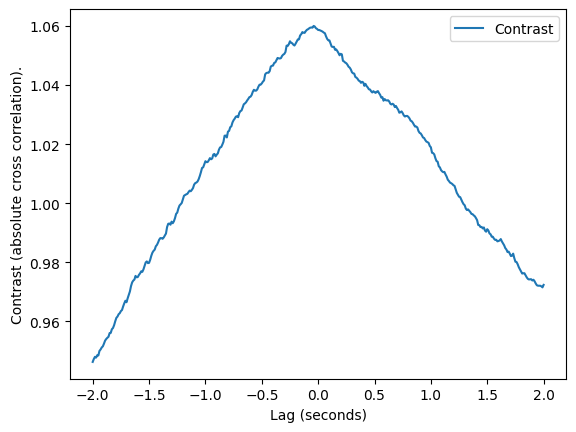

In [61]:
explore_lead_lag('BTC', '02', 'GateIO', 'BybitLinear')

Data is processed
From 2024-01-31 23:59:59.798000 til 2024-02-28 01:00:04.483000
Data is filtered
New lengths: (35348, 118655)
Running lead-lag inference: 
Estimated lag: -0.06 seconds. Positive lag means GateIO is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


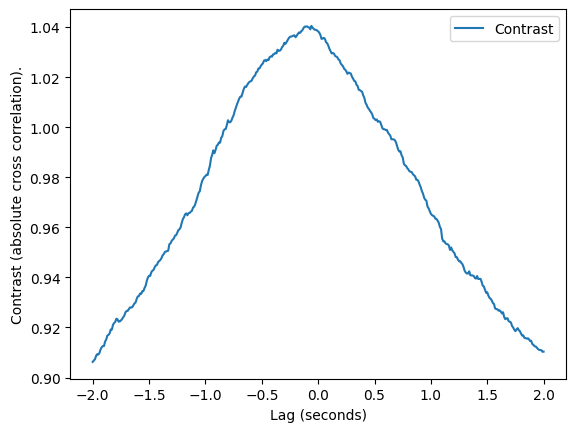

In [59]:
explore_lead_lag('BTC', '02', 'GateIO', 'OKX')

Data is processed
From 2024-01-31 23:59:59.798000 til 2024-02-28 01:00:04.483000
Data is filtered
New lengths: (35348, 352025)
Running lead-lag inference: 
Estimated lag: -0.02 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


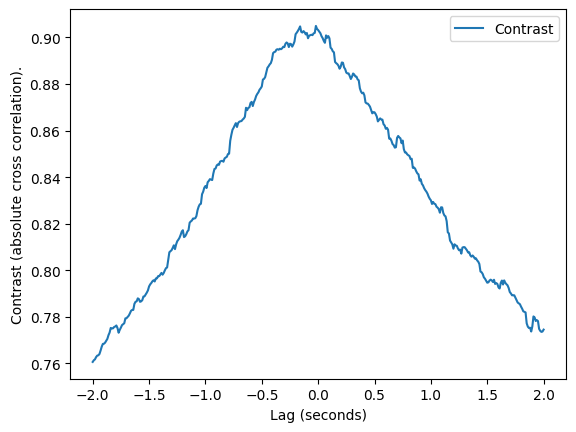

In [62]:
explore_lead_lag('BTC', '02', 'GateIO', 'Binance')

Data is processed
From 2024-01-31 23:59:59.776000 til 2024-02-28 01:00:10.585000
Data is filtered
New lengths: (118656, 352026)
Running lead-lag inference: 
Estimated lag: -0.04 seconds. Positive lag means OKX is leading.
LLR: 1.03 (cf. paper for the definition of LLR).


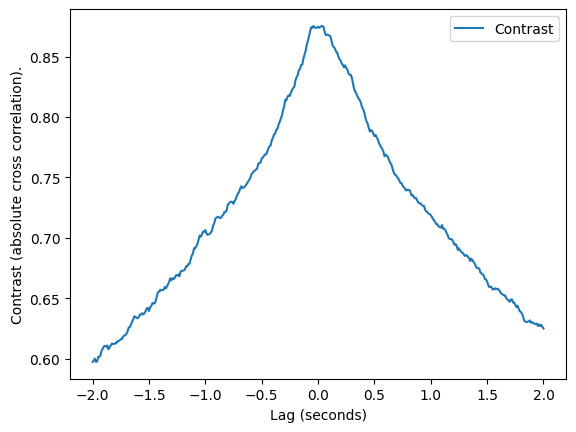

In [63]:
explore_lead_lag('BTC', '02', 'OKX', 'Binance')

Data is processed
From 2024-02-01 00:00:00.505000 til 2024-02-14 05:40:18.364000
Data is filtered
New lengths: (67488, 88079)
Running lead-lag inference: 
Estimated lag: 0.02 seconds. Positive lag means OKX is leading.
LLR: 1.03 (cf. paper for the definition of LLR).


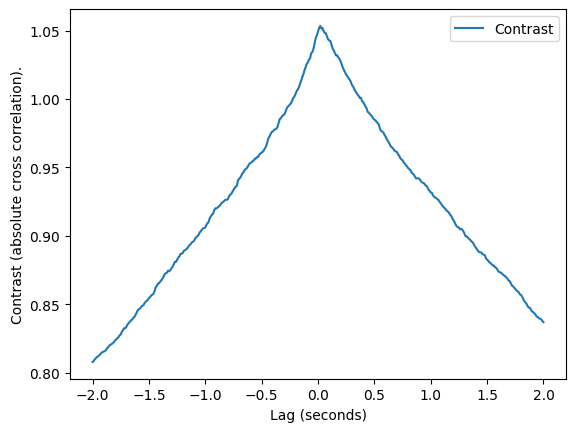

In [64]:
explore_lead_lag('BTC', '02', 'OKX', 'BybitLinear')

Data is processed
From 2024-02-01 00:00:00.505000 til 2024-02-14 05:40:18.364000
Data is filtered
New lengths: (196925, 88079)
Running lead-lag inference: 
Estimated lag: 0.05 seconds. Positive lag means Binance is leading.
LLR: 1.02 (cf. paper for the definition of LLR).


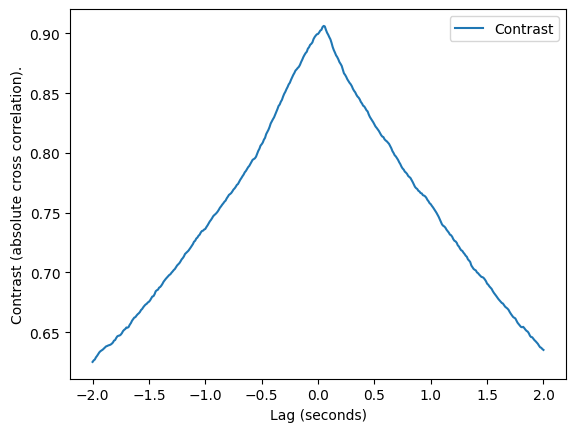

In [65]:
explore_lead_lag('BTC', '02', 'Binance', 'BybitLinear')

For BTC in February we run into a similar issue where there is not much GateIO data present. In February it is evident that BybitLinear is the leader in all comparisons by a fairly significant margin and the other exchanges were all relatively around the same lag behind it.

Data is processed
From 2024-02-01 00:00:03.795000 til 2024-02-28 01:00:06.395000
Data is filtered
New lengths: (26290, 266736)
Running lead-lag inference: 
Estimated lag: -0.12 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


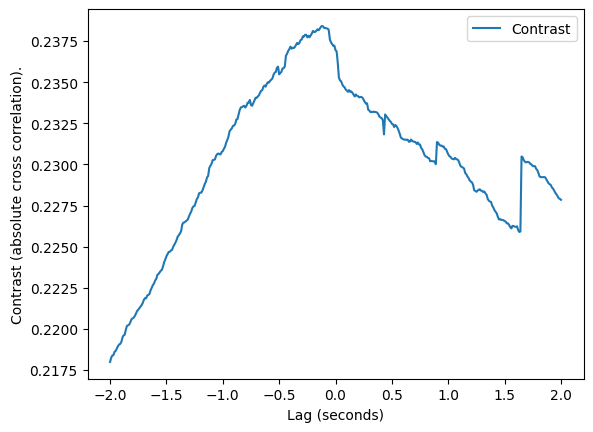

In [66]:
explore_lead_lag('ETH', '02', 'GateIO', 'Binance')

Data is processed
From 2024-02-01 00:00:03.795000 til 2024-02-14 05:40:16.430000
Data is filtered
New lengths: (13419, 38249)
Running lead-lag inference: 
Estimated lag: -0.01 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


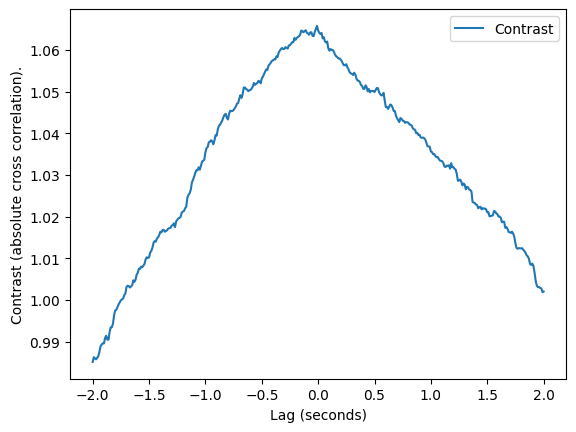

In [67]:
explore_lead_lag('ETH', '02', 'GateIO', 'BybitLinear')

Data is processed
From 2024-02-01 00:00:03.795000 til 2024-02-28 01:00:06.395000
Data is filtered
New lengths: (26290, 112007)
Running lead-lag inference: 
Estimated lag: -0.03 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


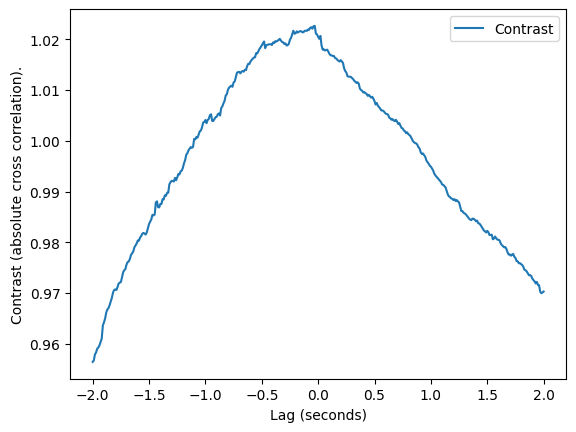

In [68]:
explore_lead_lag('ETH', '02', 'GateIO', 'OKX')

Data is processed
From 2024-01-31 23:59:59.697000 til 2024-02-28 01:01:03.759000
Data is filtered
New lengths: (112010, 266745)
Running lead-lag inference: 
Estimated lag: -0.01 seconds. Positive lag means OKX is leading.
LLR: 1.02 (cf. paper for the definition of LLR).


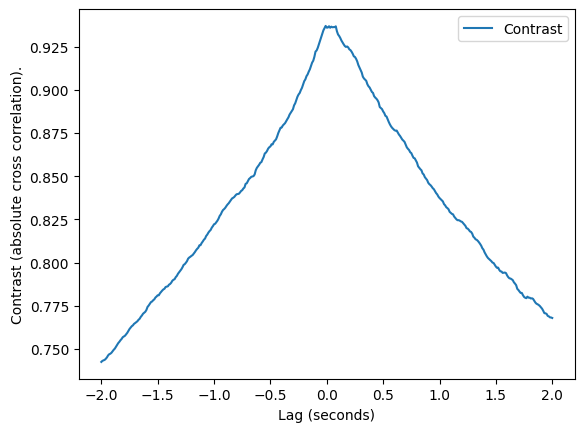

In [69]:
explore_lead_lag('ETH', '02', 'OKX', 'Binance')

Data is processed
From 2024-02-01 00:00:00.782000 til 2024-02-14 05:40:16.430000
Data is filtered
New lengths: (55289, 38249)
Running lead-lag inference: 
Estimated lag: 0.03 seconds. Positive lag means OKX is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


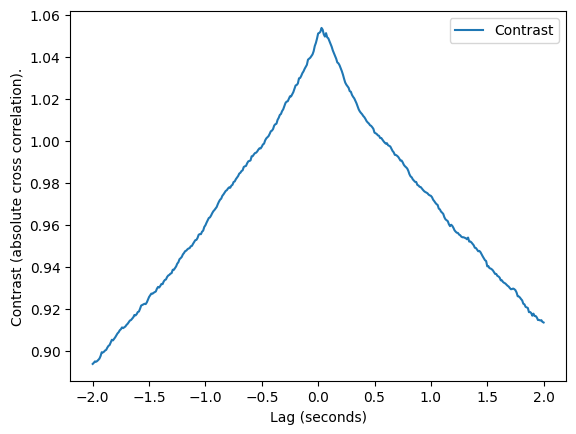

In [70]:
explore_lead_lag('ETH', '02', 'OKX', 'BybitLinear')

Data is processed
From 2024-02-01 00:00:00.782000 til 2024-02-14 05:40:16.430000
Data is filtered
New lengths: (38249, 135104)
Running lead-lag inference: 
Estimated lag: -0.05 seconds. Positive lag means BybitLinear is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


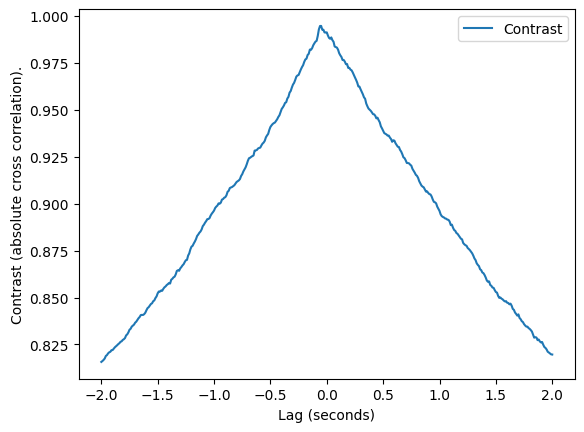

In [71]:
explore_lead_lag('ETH', '02', 'BybitLinear', 'Binance')

Data is processed
From 2024-03-01 00:00:00.190000 til 2024-03-18 00:00:00.518000
Data is filtered
New lengths: (51350, 426556)
Running lead-lag inference: 
Estimated lag: -0.09 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


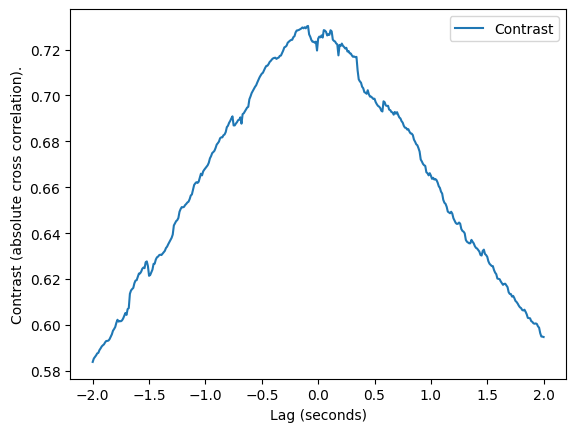

In [72]:
explore_lead_lag('BTC', '03', 'GateIO', 'Binance')

Data is processed
From 2024-03-08 08:55:04.399000 til 2024-03-18 00:00:00.760000
Data is filtered
New lengths: (33425, 132068)
Running lead-lag inference: 
Estimated lag: -0.07 seconds. Positive lag means GateIO is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


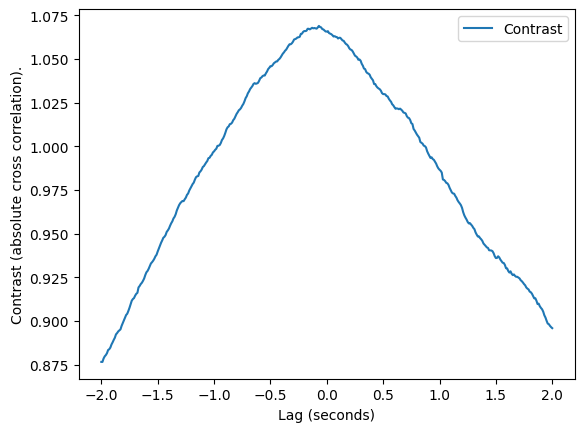

In [73]:
explore_lead_lag('BTC', '03', 'GateIO', 'BybitLinear')

Data is processed
From 2024-03-01 00:00:00.190000 til 2024-03-18 00:00:00.771000
Data is filtered
New lengths: (51350, 156331)
Running lead-lag inference: 
Estimated lag: -0.18 seconds. Positive lag means GateIO is leading.
LLR: 0.97 (cf. paper for the definition of LLR).


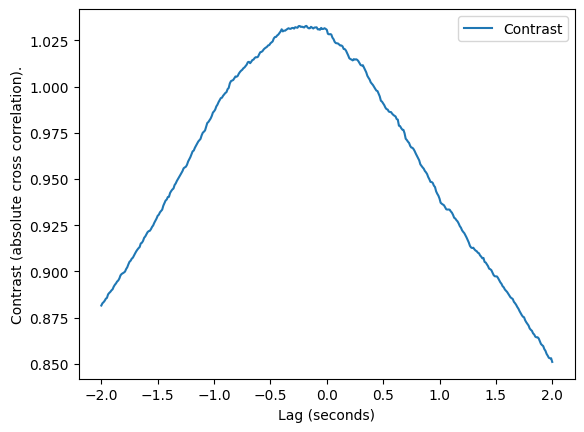

In [74]:
explore_lead_lag('BTC', '03', 'GateIO', 'OKX')

Data is processed
From 2024-02-29 23:59:59.603000 til 2024-03-18 00:00:00.518000
Data is filtered
New lengths: (156331, 426556)
Running lead-lag inference: 
Estimated lag: -0.03 seconds. Positive lag means OKX is leading.
LLR: 1.05 (cf. paper for the definition of LLR).


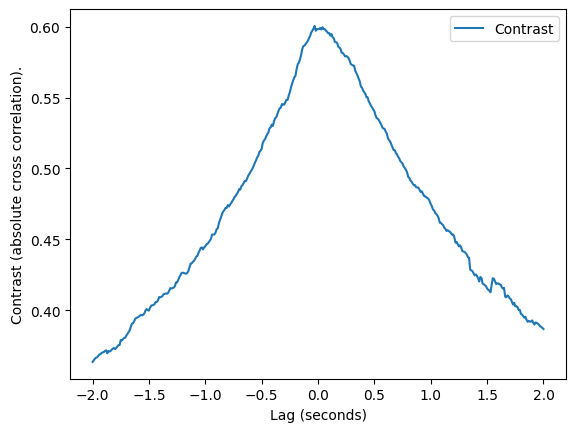

In [75]:
explore_lead_lag('BTC', '03', 'OKX', 'Binance')

Data is processed
From 2024-03-08 08:55:04.399000 til 2024-03-18 00:00:00.760000
Data is filtered
New lengths: (107054, 132068)
Running lead-lag inference: 
Estimated lag: 0.03 seconds. Positive lag means OKX is leading.
LLR: 1.03 (cf. paper for the definition of LLR).


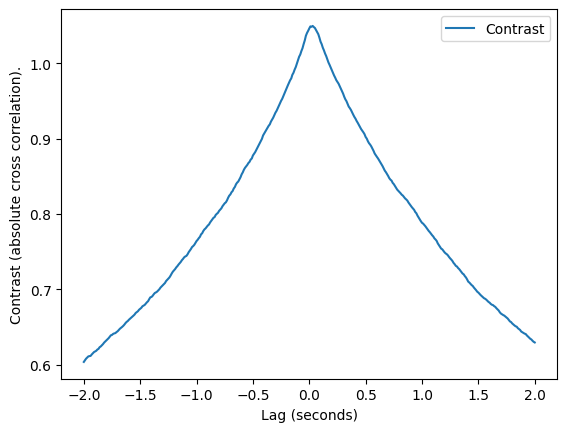

In [76]:
explore_lead_lag('BTC', '03', 'OKX', 'BybitLinear')

Data is processed
From 2024-03-08 08:55:04.399000 til 2024-03-18 00:00:00.518000
Data is filtered
New lengths: (132068, 285723)
Running lead-lag inference: 
Estimated lag: -0.03 seconds. Positive lag means BybitLinear is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


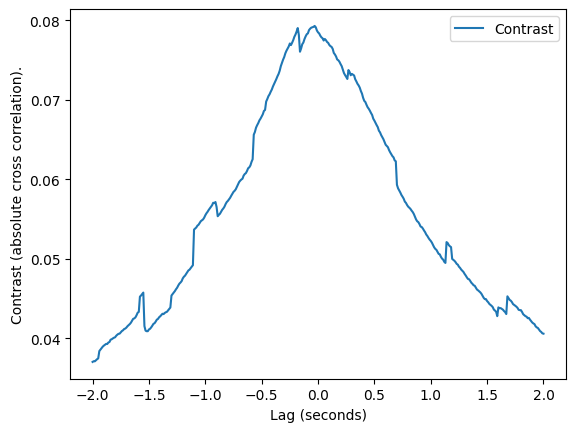

In [77]:
explore_lead_lag('BTC', '03', 'BybitLinear', 'Binance')

In [ ]:
explore_lead_lag('ETH', '03', 'GateIO', 'Binance')

Data is processed
From 2024-03-08 08:55:04.827000 til 2024-03-18 00:00:00.742000
Data is filtered
New lengths: (22294, 67749)
Running lead-lag inference: 
Estimated lag: -0.22 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


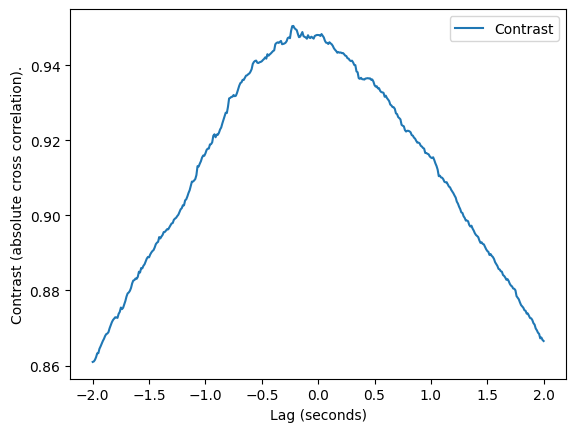

In [78]:
explore_lead_lag('ETH', '03', 'GateIO', 'BybitLinear')

Data is processed
From 2024-03-01 00:00:00.183000 til 2024-03-18 00:00:00.593000
Data is filtered
New lengths: (36299, 146561)
Running lead-lag inference: 
Estimated lag: -0.13 seconds. Positive lag means GateIO is leading.
LLR: 0.98 (cf. paper for the definition of LLR).


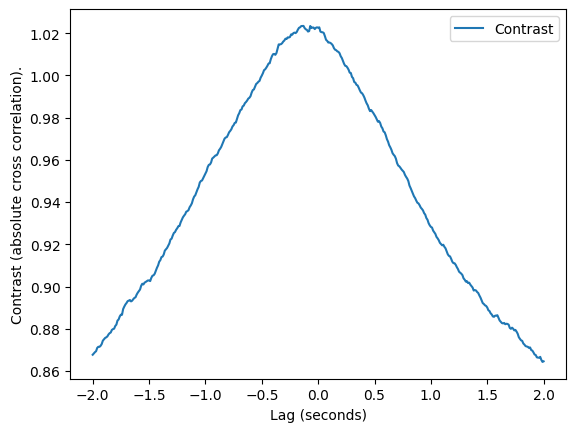

In [79]:
explore_lead_lag('ETH', '03', 'GateIO', 'OKX')

Data is processed
From 2024-03-08 08:55:04.827000 til 2024-03-18 00:00:00.517000
Data is filtered
New lengths: (67749, 201063)
Running lead-lag inference: 
Estimated lag: -0.1 seconds. Positive lag means BybitLinear is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


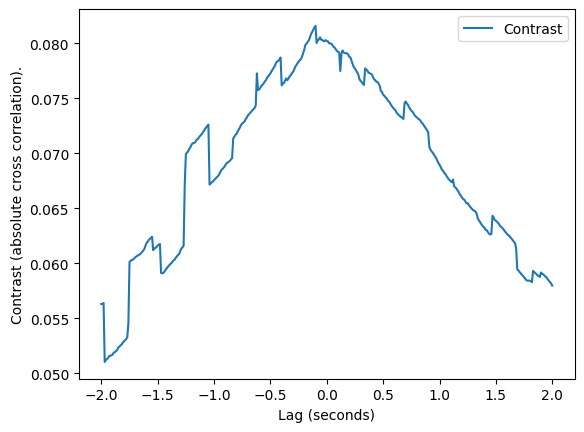

In [80]:
explore_lead_lag('ETH', '03', 'BybitLinear', 'Binance')

Data is processed
From 2024-03-08 08:55:04.827000 til 2024-03-18 00:00:00.593000
Data is filtered
New lengths: (67749, 96942)
Running lead-lag inference: 
Estimated lag: -0.02 seconds. Positive lag means BybitLinear is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


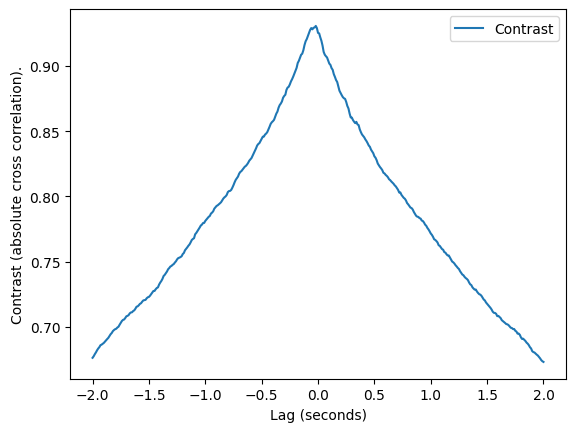

In [81]:
explore_lead_lag('ETH', '03', 'BybitLinear', 'OKX')

Data is processed
From 2024-02-29 23:59:59.631000 til 2024-03-18 00:00:00.517000
Data is filtered
New lengths: (313483, 146561)
Running lead-lag inference: 
Estimated lag: 0.02 seconds. Positive lag means Binance is leading.
LLR: 0.95 (cf. paper for the definition of LLR).


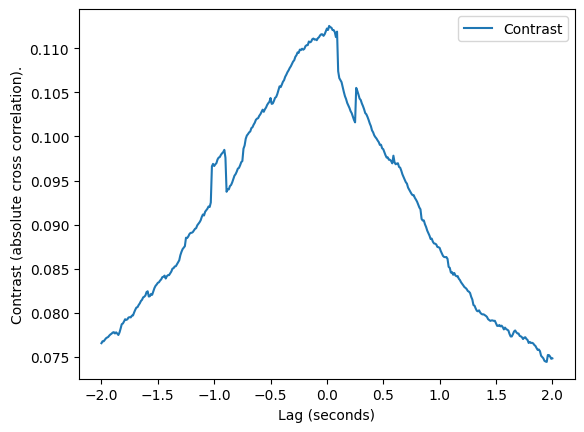

In [82]:
explore_lead_lag('ETH', '03', 'Binance', 'OKX')

Data is processed
From 2023-12-01 00:00:13.286000 til 2023-12-25 00:00:00.512000
Data is filtered
New lengths: (36751, 118099)
Running lead-lag inference: 
Estimated lag: -0.11 seconds. Positive lag means GateIO is leading.
LLR: 0.98 (cf. paper for the definition of LLR).


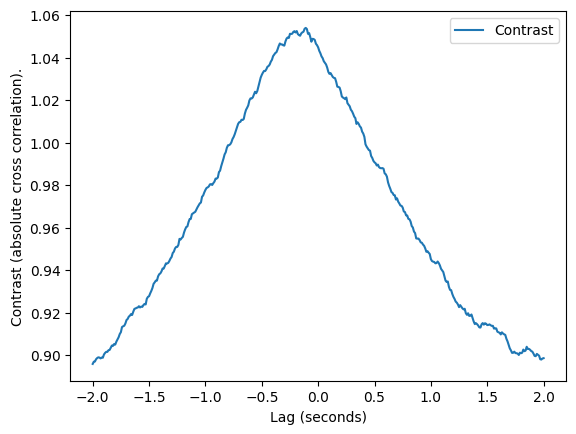

In [83]:
explore_lead_lag('BTC', '12', 'GateIO', 'OKX')

Data is processed
From 2023-12-01 00:00:08.284000 til 2023-12-25 00:00:00.758000
Data is filtered
New lengths: (36751, 157106)
Running lead-lag inference: 
Estimated lag: -0.12 seconds. Positive lag means GateIO is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


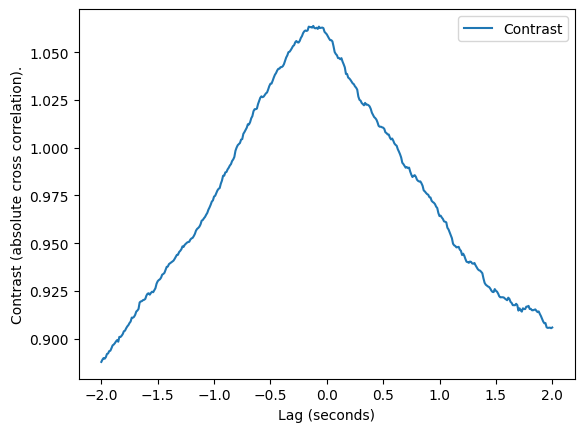

In [84]:
explore_lead_lag('BTC', '12', 'GateIO', 'BybitLinear')

Data is processed
From 2023-12-01 00:00:08.284000 til 2023-12-25 00:00:00.495000
Data is filtered
New lengths: (36751, 262391)
Running lead-lag inference: 
Estimated lag: -0.05 seconds. Positive lag means GateIO is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


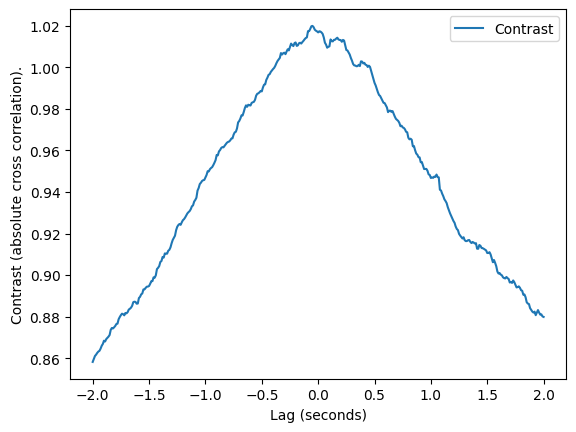

In [85]:
explore_lead_lag('BTC', '12', 'GateIO', 'Binance')

Data is processed
From 2023-12-01 00:00:13.286000 til 2023-12-25 00:00:00.495000
Data is filtered
New lengths: (118099, 262390)
Running lead-lag inference: 
Estimated lag: -0.03 seconds. Positive lag means OKX is leading.
LLR: 1.02 (cf. paper for the definition of LLR).


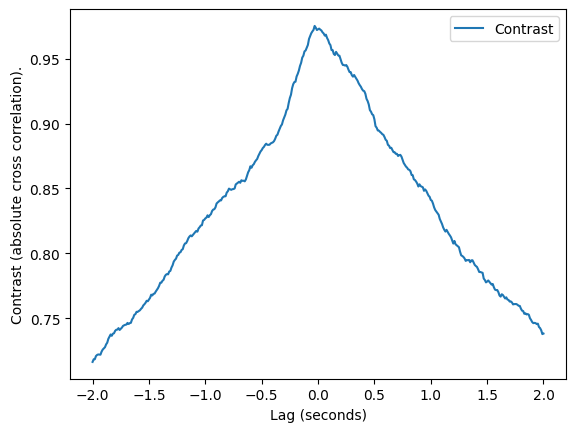

In [86]:
explore_lead_lag('BTC', '12', 'OKX', 'Binance')

Data is processed
From 2023-12-01 00:00:13.286000 til 2023-12-25 00:00:00.512000
Data is filtered
New lengths: (118099, 157105)
Running lead-lag inference: 
Estimated lag: 0.04 seconds. Positive lag means OKX is leading.
LLR: 1.03 (cf. paper for the definition of LLR).


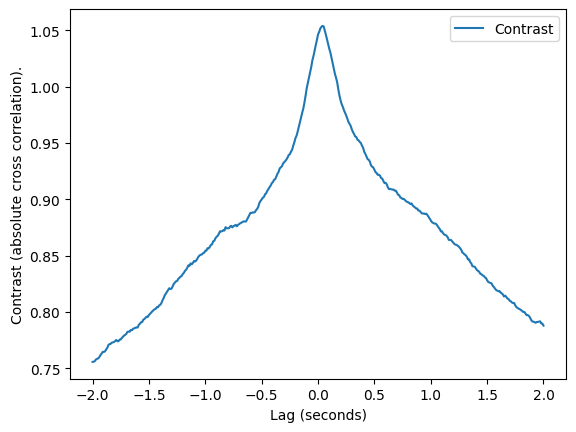

In [87]:
explore_lead_lag('BTC', '12', 'OKX', 'BybitLinear')

Data is processed
From 2023-12-01 00:00:03.667000 til 2023-12-25 00:00:00.495000
Data is filtered
New lengths: (157106, 262392)
Running lead-lag inference: 
Estimated lag: -0.06 seconds. Positive lag means BybitLinear is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


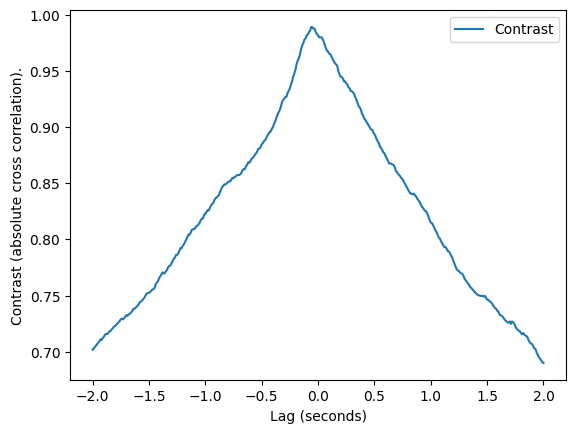

In [88]:
explore_lead_lag('BTC', '12', 'BybitLinear', 'Binance')

Data is processed
From 2023-12-01 00:00:12.197000 til 2023-12-25 00:00:00.616000
Data is filtered
New lengths: (30347, 117143)
Running lead-lag inference: 
Estimated lag: -0.04 seconds. Positive lag means GateIO is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


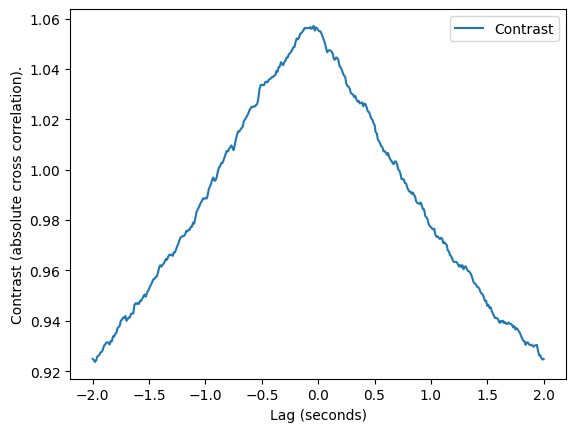

In [89]:
explore_lead_lag('ETH', '12', 'GateIO', 'OKX')

Data is processed
From 2023-12-01 00:00:03.157000 til 2023-12-25 00:00:00.988000
Data is filtered
New lengths: (30347, 87851)
Running lead-lag inference: 
Estimated lag: -0.1 seconds. Positive lag means GateIO is leading.
LLR: 0.99 (cf. paper for the definition of LLR).


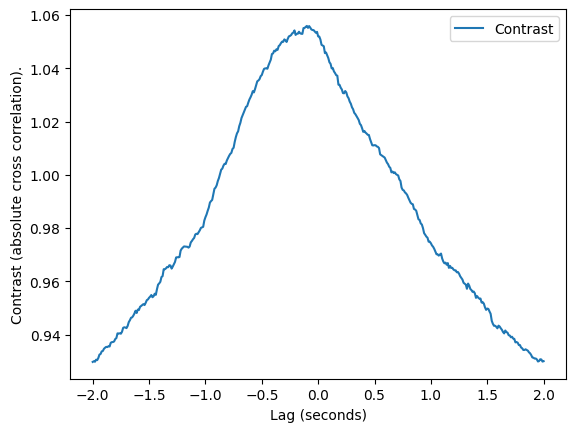

In [90]:
explore_lead_lag('ETH', '12', 'GateIO', 'BybitLinear')

Data is processed
From 2023-12-01 00:00:03.157000 til 2023-12-25 00:00:00.532000
Data is filtered
New lengths: (30347, 195465)
Running lead-lag inference: 
Estimated lag: 0.04 seconds. Positive lag means GateIO is leading.
LLR: 1.00 (cf. paper for the definition of LLR).


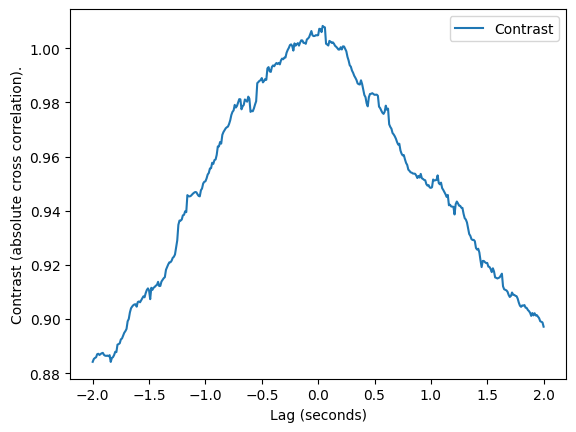

In [91]:
explore_lead_lag('ETH', '12', 'GateIO', 'Binance')

Data is processed
From 2023-12-01 00:00:12.197000 til 2023-12-25 00:00:00.616000
Data is filtered
New lengths: (117143, 87850)
Running lead-lag inference: 
Estimated lag: 0.04 seconds. Positive lag means OKX is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


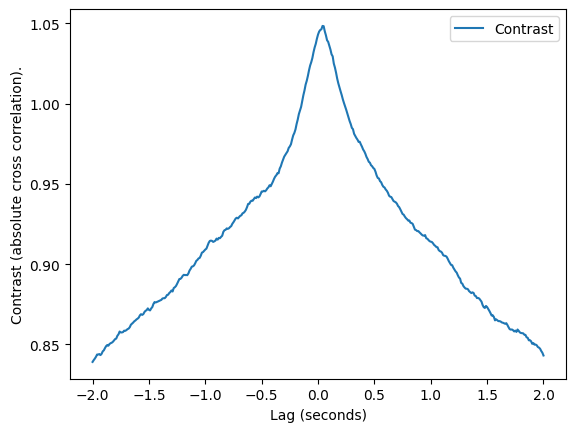

In [92]:
explore_lead_lag('ETH', '12', 'OKX', 'BybitLinear')

Data is processed
From 2023-12-01 00:00:12.197000 til 2023-12-25 00:00:00.532000
Data is filtered
New lengths: (117143, 195463)
Running lead-lag inference: 
Estimated lag: 0.06 seconds. Positive lag means OKX is leading.
LLR: 1.02 (cf. paper for the definition of LLR).


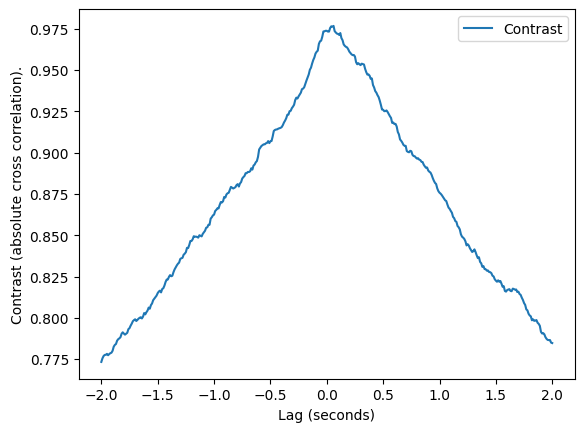

In [93]:
explore_lead_lag('ETH', '12', 'OKX', 'Binance')

Data is processed
From 2023-12-01 00:00:01.355000 til 2023-12-25 00:00:00.532000
Data is filtered
New lengths: (87851, 195466)
Running lead-lag inference: 
Estimated lag: 0.05 seconds. Positive lag means BybitLinear is leading.
LLR: 1.01 (cf. paper for the definition of LLR).


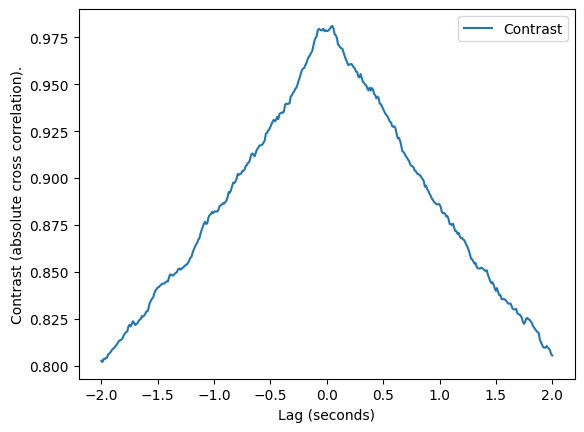

In [94]:
explore_lead_lag('ETH', '12', 'BybitLinear', 'Binance')

Overall trends:

Sometimes the analysis can be slighly erratic as it suggests contradicting effects of time series, but this can be resolved with a greater granularity of data. Something else that will be able to help is more consistent data in terms of the range of times covered by each time series. Sometimes there is minimal overlap which causes the "fitting" portion of the lead-lag model to be inaccurate.

Overall: GateIO across all months and assets seems to be slightly behind in general of the other 3 exchanges. This may be a function of their geographic location and day to day user bases.